In [5]:
#!pipi install tensorflow-datasets

In [6]:
#!pip install tfds-nightly

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

ds =tfds.load('lost_and_found', split = 'train', batch_size = 200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incomplete8VS0DP/lost_and_found-train.tfrecord


  0%|          | 0/1036 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incomplete8VS0DP/lost_and_found-test.tfrecord


  0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [8]:
dataset = next(iter(ds))
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [9]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [10]:
labels[labels>1] = 1

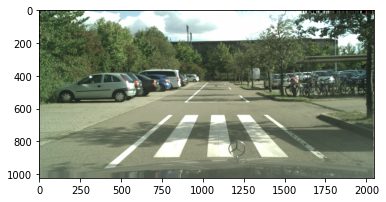

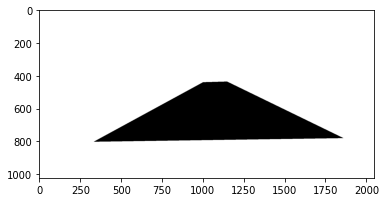

In [11]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap = 'binary')
plt.show()

In [12]:
# images를 resize해서 a에 담기 
import cv2

a = []
for i in range(0, 200, 1):
  res =cv2.resize(images[i], dsize = (256,256), interpolation = cv2.INTER_NEAREST)
  a.append(res)

In [13]:
b = []
for i in range(0, 200, 1):
  rest =cv2.resize(labels[i], dsize = (256,256), interpolation = cv2.INTER_NEAREST)
  b.append(rest)

In [14]:
# x = images.astype('float32') / 255.
# y = labels.astype('float32')

In [15]:
import numpy as np
x = np.array(a)
y = np.array(b)

In [16]:
y = np.expand_dims(y, axis=-1)

In [17]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [18]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256, 1)
(40, 256, 256, 3)
(40, 256, 256, 1)


train


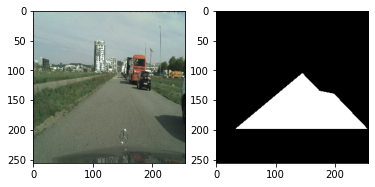

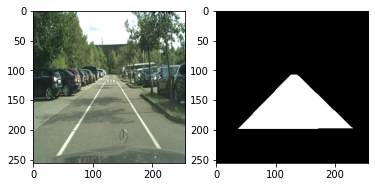

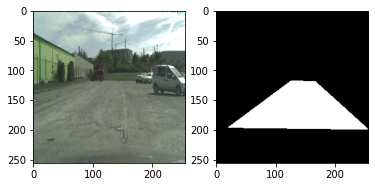

test


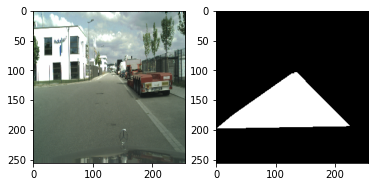

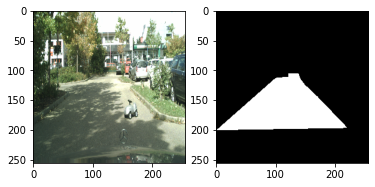

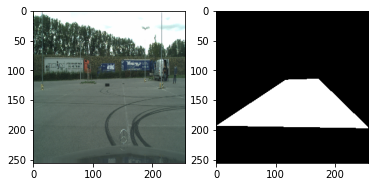

In [19]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

# Unet 모델 적용

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

# 모델 컴파일과 학습

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=200, batch_size=8, verbose=1)


# 학습 시 loss와 acc 보기

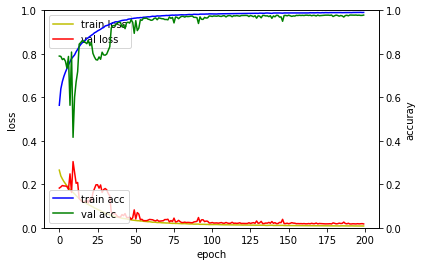

In [22]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 테스트 결과 보기

In [23]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 499ms/step - loss: 0.0059 - accuracy: 0.9936


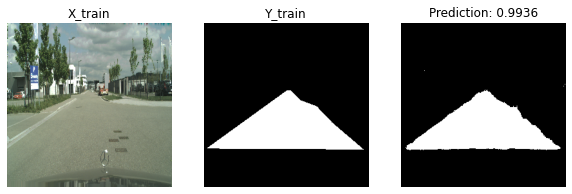

1/1 [==============================] - 0s 27ms/step - loss: 0.0148 - accuracy: 0.9830


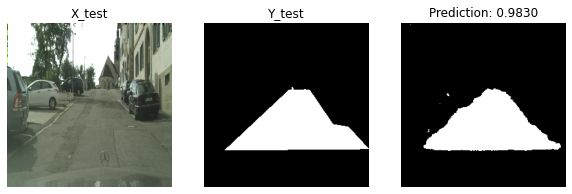

In [24]:
plotPredictions(model, train_x, train_y, test_x, test_y)